In [13]:
import pandas as pd
import numpy as np
import math
import os
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.decomposition import PCA                 # for dimensionality reduction using PCA
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import classification_report,confusion_matrix
import matplotlib.pyplot as plt 
import seaborn as sns            # visualization tool
import matplotlib.cm as cm       # for colour mapping to use for the pca plots
import scipy.signal
from spectrum import *

In [16]:
def process_one_csv(foldername,k,filename):
    # print(foldername,filename)
    path = '/home/amaya/emp/Realtime-Sign-Language-Translation-to-Speech-DNN/NEW_PROCESS/FULL_CLEANED2/'+foldername+'/split/'+k+'/'+filename
    f = open(path,'rb')
    if b',' in f.readline():
        data = pd.read_csv(path)
    else:
        data = pd.read_csv(path,encoding = 'utf-16',delimiter = '\t')
    data = data.drop('Timestamp',axis = 1)
    # print(data.head(2))
    
    columns = list(data.columns)

    #features = ['E','MAX','SSC','Sk','Ku','AR']

    vector = []
    #out_columns = []
    
    for item in columns:
        temp = list(data[item])
        l = len(temp)
        
        # calculating mean
        mu = np.mean(np.array(temp))
        
        # calculating std
        dif = temp - mu
        s = np.sqrt(np.mean(np.array(dif)**2))
        
        # calculating E ***
        #out_columns.append(item+features[0])
        vector.append(np.mean(np.array(temp)**2))
        
        # calculating max ***
        #out_columns.append(item+features[1])
        vector.append(max(temp))
        
        # calculating SSC ***
        #out_columns.append(item+features[2])
        tot = 0
        for i in range(1,l-1): 
            if (temp[i]-temp[i-1])*(temp[i+1]-temp[i]) < 0:
                tot += 1
        vector.append(tot/l-2)

    return vector

In [17]:
output = []
classes=[]
folders = os.listdir('/home/amaya/emp/Realtime-Sign-Language-Translation-to-Speech-DNN/NEW_PROCESS/FULL_CLEANED2/')
# process_one_csv(files[0])
for folder in folders:
    if folder[0] != '.':
        class_ = folder[:-11]
        
        for k in ['1', '2']:
            files = os.listdir('/home/amaya/emp/Realtime-Sign-Language-Translation-to-Speech-DNN/NEW_PROCESS/FULL_CLEANED2/'+folder+'/split/'+k+'/')
            temp = []
            for file in files:
                if file[-1] == 'v' and 'gyro' in file:
                    temp += process_one_csv(folder,k,file)
            if class_ in classes:
                temp.append(classes.index(class_))
            else:
                classes.append(class_)
                temp.append(classes.index(class_))
            
            output.append(temp)
            
processed = pd.DataFrame(output)
ocolumns = list(processed.columns)
processed.head()
print(classes)

['YELLOW', 'WATER', 'YES', 'THANKYOU', 'NO']


In [18]:
processed.head()

,0,1,2,3,4,5,6,7,8,9
0,1102.491401,42.871890,-1.931937,2313.491837,74.722949,-1.984293,1317.906575,54.524040,-1.984293,0
1,885.682984,36.748547,-1.924623,1983.106925,70.611385,-1.984925,1148.560591,50.985131,-1.984925,0
2,968.808077,42.873981,-1.951327,2317.918867,80.597075,-1.986726,952.529188,50.249259,-1.986726,0
3,816.347656,37.948618,-1.947867,2471.691043,80.317119,-1.985782,926.636653,49.259067,-1.966825,0
4,403.636721,25.305731,-1.936585,5655.153686,115.683595,-1.985366,590.178219,39.452069,-1.956098,1


In [19]:
len(ocolumns)

10

In [20]:
processed.shape

(136, 10)

In [21]:
X = processed[ocolumns[:-1]]
y = processed[ocolumns[-1]]

In [22]:
scaler = preprocessing.MinMaxScaler()   # since the data set is not gaussian
scaled_df = scaler.fit_transform(X)
X = pd.DataFrame(scaled_df,columns = ocolumns[:-1])
y = processed[ocolumns[-1]]

In [24]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.20)

In [25]:
svclassifier = SVC(kernel = 'linear',C = 10.0, gamma = 1.0)
# C = 100.0, gamma = 1.0 for linear kernel - selected using GridSearchCV

svclassifier.fit(X_train,y_train)

SVC(C=10.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=1.0, kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

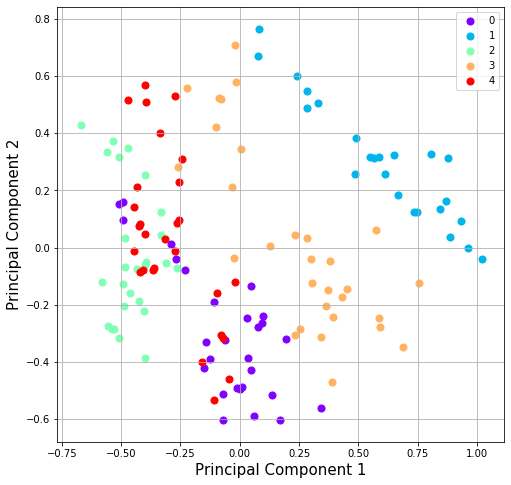

In [26]:
# dimensionality reduction to training set

pca = PCA(n_components = 2)
newFeatures = pca.fit_transform(X)
newdf = pd.DataFrame(newFeatures,columns = ['Principal Component 1', 'Principal Component 2'])
#svclassifier.fit(newdf,y)
newdf['CLASS'] = list(y)

fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
clind = list(range(5))
colors = cm.rainbow(np.linspace(0, 1, 5))
for ind, color in zip(clind,colors):
    indicesToKeep = newdf['CLASS'] == ind
    ax.scatter(newdf.loc[indicesToKeep, 'Principal Component 1']
               , newdf.loc[indicesToKeep, 'Principal Component 2']
               , c = color
               , s = 50)
ax.legend(clind)
ax.grid()

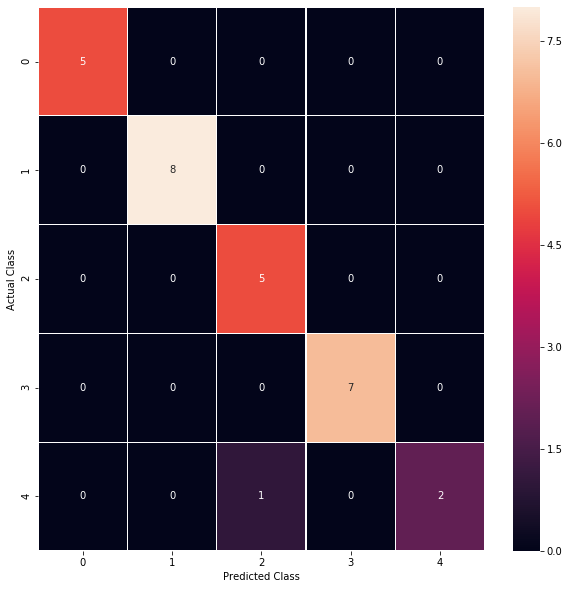

[3, 1, 2, 2, 0, 4, 0, 2, 0, 1, 1, 3, 4, 1, 1, 0, 3, 3, 2, 1, 3, 4, 1, 3, 2, 3, 1, 0] [3, 1, 2, 2, 0, 4, 0, 2, 0, 1, 1, 3, 2, 1, 1, 0, 3, 3, 2, 1, 3, 4, 1, 3, 2, 3, 1, 0]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         8
           2       0.83      1.00      0.91         5
           3       1.00      1.00      1.00         7
           4       1.00      0.67      0.80         3

    accuracy                           0.96        28
   macro avg       0.97      0.93      0.94        28
weighted avg       0.97      0.96      0.96        28



In [27]:
# dimesionality reduction to test set
# newFeaturesTest = pca.fit_transform(X_test)
# newtest = pd.DataFrame(newFeaturesTest,columns = ['Principal Component 1', 'Principal Component 2'])
# ****************************************************************************************************

# Usual code:
y_pred = svclassifier.predict(X_test)
#result = [y_pred[i] == y_test[i] for i in range(len(y_test))]
f,ax = plt.subplots(figsize=(10, 10))
sns.heatmap(confusion_matrix(y_test,y_pred), annot=True, linewidths=.1, fmt= '.0f',ax=ax).set_ylim(5,0)
plt.xlabel("Predicted Class")
plt.ylabel("Actual Class")
plt.show()
print(list(y_test),list(y_pred))
print(classification_report(y_test,y_pred))

In [29]:
# parameter tuning

param_grid = {'C': [0.01,0.1, 1, 10, 100,1000]}
clf_grid = GridSearchCV(SVC(kernel = 'linear'), param_grid)
clf_grid.fit(X, y)
print("Best Parameters:\n", clf_grid.best_params_)

Best Parameters:
 {'C': 10}


/home/amaya/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/home/amaya/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
